In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm.auto import tqdm  
import spacy # pip install spacy==2.2.4
import nltk
nltk.download('words')
from nltk.corpus import words
import warnings

warnings.filterwarnings("ignore")

from src.data.process_pdfs import convert_pdf_to_txt

[nltk_data] Downloading package words to /home/jbaumert/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Load cleaned text already masked by spaCy

In [20]:
df = pd.read_pickle('data/processed/reports_tokenized_spacy.p')
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth one world leading online betting gaming company org...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


## 2. Mask company names with own function

In [5]:
# Step 2: Custom (mask each word in company name)

for index, row in df.iterrows():
    words = row['Company_Name'].split()
    for word in words:
        df.loc[index, 'CSR_Text_clean'] = df.loc[index, 'CSR_Text_clean'].replace(word,'ORG2').replace(word.lower(),'ORG2').replace(word.upper(),'ORG2')

## 3. Analyze masking

In [21]:
import re

def count_words_ORG(text):
    count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('ORG'), text))
    return count

def count_words_ORG2(text):
    count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('ORG2'), text))
    return count

In [22]:
tqdm.pandas() # Display progressbar
df['ORG_count'] = df['CSR_Text_clean'].progress_apply(count_words_ORG)

tqdm.pandas() # Display progressbar
df['ORG2_count'] = df['CSR_Text_clean'].progress_apply(count_words_ORG2)

  0%|          | 0/8141 [00:00<?, ?it/s]

  0%|          | 0/8141 [00:00<?, ?it/s]

(array([3.765e+03, 2.074e+03, 8.900e+02, 3.990e+02, 3.060e+02, 2.440e+02,
        1.840e+02, 1.040e+02, 5.900e+01, 4.500e+01, 2.200e+01, 1.500e+01,
        1.200e+01, 5.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 7.000e+00,
        1.000e+00, 3.000e+00]),
 array([   0. ,  403.1,  806.2, 1209.3, 1612.4, 2015.5, 2418.6, 2821.7,
        3224.8, 3627.9, 4031. , 4434.1, 4837.2, 5240.3, 5643.4, 6046.5,
        6449.6, 6852.7, 7255.8, 7658.9, 8062. ]),
 <BarContainer object of 20 artists>)

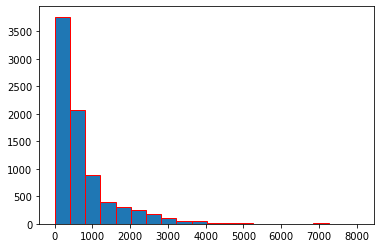

In [8]:
plt.hist(df['ORG_count'], bins=20, edgecolor="red")

Text(0, 0.5, 'Masked words')

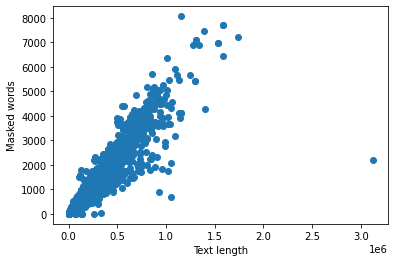

In [17]:
plt.scatter(df['CSR_Text_clean'].str.len(), df['ORG_count'])
plt.xlabel('Text length')
plt.ylabel('Masked words')

(array([7.404e+03, 5.380e+02, 1.170e+02, 2.900e+01, 1.000e+01, 1.000e+01,
        4.000e+00, 3.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([   0. ,  345.8,  691.6, 1037.4, 1383.2, 1729. , 2074.8, 2420.6,
        2766.4, 3112.2, 3458. , 3803.8, 4149.6, 4495.4, 4841.2, 5187. ,
        5532.8, 5878.6, 6224.4, 6570.2, 6916. ]),
 <BarContainer object of 20 artists>)

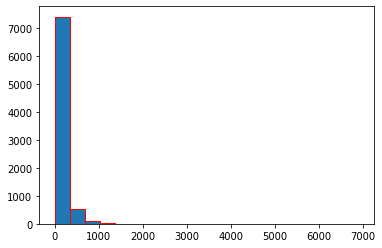

In [9]:
plt.hist(df['ORG2_count'], bins=20, edgecolor="red")

Text(0, 0.5, 'Masked words')

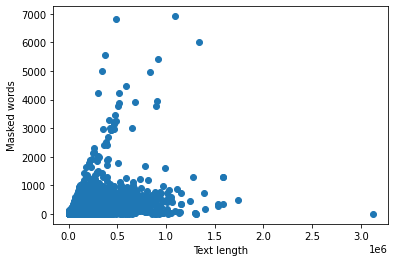

In [18]:
plt.scatter(df['CSR_Text_clean'].str.len(), df['ORG2_count'])
plt.xlabel('Text length')
plt.ylabel('Masked words')

In [41]:
pd.set_option("display.max_rows", None)
df[(df['ORG2_count'] > 1000) & (df['CSR_Text_clean'].str.len() < 500000)]

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized,ORG_count,ORG2_count
75,100,ANZ.AX,Australia and New Zealand Banking Group Ltd,AU000000ANZ3,ANZ,Australia,2020,FY0,https://www.anz.com.au/content/dam/anzcom/shareholder/ANZ-2020-ESG-Supplement.pdf,True,False,True,True,True,True,True,True,True,NaN,True,True,True,NaN,True,True,True,100_ANZ.AX_2020.pdf,2 0 2 0 E S G S U P P L E M E N T Overview Fair ORG2 responsible ORG2 Environmental sustainabili...,e g u p p l e e n overview fair responsible banking environmental sustainability housing financi...,1357,2970
128,169,AWK.N,American Water Works Company Inc,US0304201033,AWK,United States of America,2020,FY0,https://s26.q4cdn.com/750150140/files/doc_downloads/esg_docs/2021/2019-2020-Sustainability-Repor...,True,False,True,True,True,True,True,True,False,NaN,True,True,True,NaN,False,True,True,169_AWK.N_2020.pdf,VITAL EFFICIENT SUSTAINABLE 20192020 SUSTAINABILITY REPORT Contents About This Report.3 Greeting...,vital efficient sustainable sustainability report content report greeting president ceo american...,1020,1092
151,203,BDX.N,Becton Dickinson and Co,US0758871091,BDX,United States of America,2020,FY0,https://www.bd.com/documents/corporate/BD_Sustainability-report-2020_EN.pdf,False,False,True,True,True,True,True,True,True,NaN,False,True,True,NaN,False,True,False,203_BDX.N_2020.pdf,Headline 60/60 FS Albert Thin FY 2020 Sustainability Report To our stakeholders In the extraordi...,headline f albert thin fy sustainability report stakeholder extraordinary year saw myriad way he...,1575,1843
152,206,BEN.AX,Bendigo and Adelaide Bank Ltd,AU000000BEN6,BEN,Australia,2020,FY0,https://www.bendigoadelaide.com.au/shareholders/pdf/annual_reports/2020-Annual-Review.pdf,True,False,True,True,True,True,True,False,False,NaN,True,True,True,NaN,False,False,True,206_BEN.AX_2020.pdf,"Annual Review 2020 Front Cover Small businesses come in all shapes ORG2 sizes, ORG2 every busine...",annual review front cover small business come shape size every business operates different circu...,516,1022
184,243,BMO.TO,Bank of Montreal,CA0636711016,BMO,Canada,2020,FY0,https://our-impact.bmo.com/wp-content/uploads/2021/03/BMO-2020-ESG-PAS-accessible-1-1.pdf,True,False,True,True,True,True,True,True,True,NaN,True,True,True,NaN,True,True,True,243_BMO.TO_2020.pdf,ORG ORG Statement Index Growing the Good for a Sustainable Future Growing the Good for a Thrivin...,org org statement index growing good sustainable future growing good thriving economy growing go...,2032,1874
326,410,CTA_pa.N,E I Du Pont De Nemours and Co,US2635342080,CTA PR A,United States of America,2016,FY0,http://www.dupont.com/content/dam/dupont/corporate/our-approach/sustainability/2017-Documents/20...,False,True,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,410_CTA_pa.N_2016.pdf,ORG 2017 GLOBAL RORG2PORTORG2NG ORG2NORG2TORG2ATORG2VORG2 RORG2PORT TABLORG2 OF ORG2NTORG2NTS OR...,org global reporting initiative report table content introduction org management approach report...,890,1459
651,830,JKX.L,JKX Oil and Gas PLC,GB0004697420,JKX,United Kingdom,2020,FY0,https://www.jkx.co.uk/~/media/Files/J/JKX-V2/download-centre/annual-report-2020-v2.pdf,False,False,True,False,False,False,False,False,False,NaN,False,False,True,NaN,False,False,False,830_JKX.L_2020.pdf,ORG 2020 Annual Report ORG Annual Report 2020 In this report Strategic report How we performed t...,org annual report org annual report report strategic report performed year business chairman sta...,2181,3216
859,1100,OI.N,O-I Glass Inc,US67098H1041,OI,United States of America,2020,FY0,https://www.o-i.com/wp-content/uploads/2021/09/O-I_SustainabilityReport_2021.pdf,False,False,True,False,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,1

## 4. Analyze new masking

In [5]:
df = pd.read_pickle('data/processed/reports_tokenized_spacy.p')
df.drop(columns=['CSR_Text_tokenized'], inplace=True)
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEADING O...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...


In [6]:
# Step 2: Custom (mask each word in company name if not in nltk english words)

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Split company name into words
    company_words = row['Company_Name'].split()
    for word in company_words:
        # Exclude "normal" english words
        if (word not in words.words()) and (word.lower() not in words.words()):
            # Add spaces before and after word to prevent replacing parts of words
            word = ' ' + word + ' '   
            df.loc[index, 'CSR_Text_clean'] = df.loc[index, 'CSR_Text_clean'].replace(word,' ORG2 ').replace(word.lower(),' ORG2 ').replace(word.upper(),' ORG2 ')

  0%|          | 0/8141 [00:00<?, ?it/s]

In [7]:
# TEMP: analysis
import re

def count_words_ORG2(text):
    count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('ORG2'), text))
    return count

tqdm.pandas() # Display progressbar
df['ORG2_count'] = df['CSR_Text_clean'].progress_apply(count_words_ORG2)

  0%|          | 0/8141 [00:00<?, ?it/s]

(array([5.966e+03, 1.083e+03, 5.170e+02, 2.260e+02, 1.200e+02, 7.300e+01,
        5.900e+01, 3.900e+01, 1.500e+01, 1.500e+01, 6.000e+00, 8.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0.  ,   57.45,  114.9 ,  172.35,  229.8 ,  287.25,  344.7 ,
         402.15,  459.6 ,  517.05,  574.5 ,  631.95,  689.4 ,  746.85,
         804.3 ,  861.75,  919.2 ,  976.65, 1034.1 , 1091.55, 1149.  ]),
 <BarContainer object of 20 artists>)

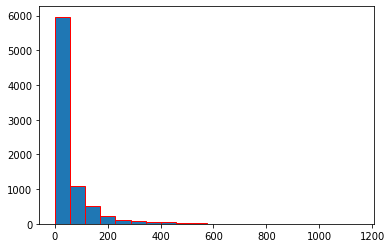

In [8]:
plt.hist(df['ORG2_count'], bins=20, edgecolor="red")

Text(0, 0.5, 'Masked words')

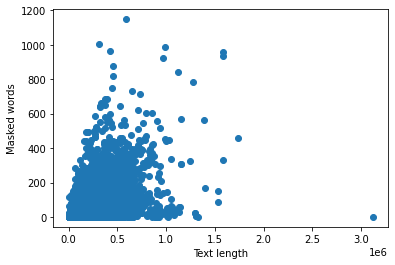

In [9]:
plt.scatter(df['CSR_Text_clean'].str.len(), df['ORG2_count'])
plt.xlabel('Text length')
plt.ylabel('Masked words')

In [10]:
len(df[df['ORG2_count'] > 0])

6224

In [11]:
df[df['CSR_Text_clean'].str.len() > 3000000]

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,ORG2_count
441,547,ETSY.OQ,ETSY Inc,US29786A1060,ETSY,United States of America,2020,FY0,https://s22.q4cdn.com/941741262/files/doc_financials/2020/ar/2020-Integrated-Annual-Report_final...,False,False,False,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,547_ETSY.OQ_2020.pdf,2020 Integrated Annual Report Keep Commerce Human 2020 was a year that needs no introduction. It...,0
